In [1]:
%load_ext zipline
%matplotlib inline
import seaborn

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import sys
import logbook
import numpy as np
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission
from zipline.api import order_target, record, symbol, history

In [3]:
#!/usr/bin/env python
#
# Copyright 2014 Quantopian, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Dual Moving Average Crossover algorithm.
This algorithm buys apple once its short moving average crosses
its long moving average (indicating upwards momentum) and sells
its shares once the averages cross again (indicating downwards
momentum).
"""

from zipline.api import order_target, record, symbol


def initialize(context):
    context.sym = symbol('AAPL')
    context.i = 0


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.sym, 'price', 100, '1d').mean()
    long_mavg = data.history(context.sym, 'price', 300, '1d').mean()
    volatility = data.history(context.sym, 'price', 100, '1d').std() * 16

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.sym, 100)
    elif short_mavg < long_mavg:
        order_target(context.sym, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.sym, "price"),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if ('AAPL' in results and 'short_mavg' in results and
            'long_mavg' in results):
        results['AAPL'].plot(ax=ax2)
        results[['short_mavg', 'long_mavg']].plot(ax=ax2)

        trans = results.ix[[t != [] for t in results.transactions]]
        buys = trans.ix[[t[0]['amount'] > 0 for t in
                         trans.transactions]]
        sells = trans.ix[
            [t[0]['amount'] < 0 for t in trans.transactions]]
        ax2.plot(buys.index, results.short_mavg.ix[buys.index],
                 '^', markersize=10, color='m')
        ax2.plot(sells.index, results.short_mavg.ix[sells.index],
                 'v', markersize=10, color='k')
        plt.legend(loc=0)
    else:
        msg = 'AAPL, short_mavg & long_mavg data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()


def _test_args():
    """Extra arguments to use when zipline's automated tests run this example.
    """
    import pandas as pd

    return {
        'start': pd.Timestamp('2011', tz='utc'),
        'end': pd.Timestamp('2013', tz='utc'),
    }

In [5]:
start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)

STOCKS=['AAPL']
# Load price data from yahoo.
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()

# Create and run the algorithm.
olmar = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
results = olmar.run(data)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=19).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=23).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Se

In [6]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)


Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics,All history,Backtest,Out of sample
annual_return,0.00,0.00,0.00
annual_volatility,0.01,0.01,0.01
sharpe_ratio,0.46,0.46,0.56
calmar_ratio,0.17,0.16,1.61
stability_of_timeseries,0.77,0.76,0.28
max_drawdown,-0.01,-0.01,-0.00
omega_ratio,1.11,1.11,1.09
sortino_ratio,0.63,0.62,0.83
skew,-0.83,-0.91,0.18
kurtosis,11.14,12.00,0.11


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,1.42,2007-12-28,2008-10-09,NaT,NaN
1,0.49,2007-11-06,2007-11-12,2007-12-07,24
2,0.45,2006-01-13,2006-07-14,2006-11-16,220
3,0.37,2007-07-26,2007-08-16,2007-09-24,43
4,0.18,2007-01-16,2007-02-09,2007-04-26,73




[-0.001 -0.001]


/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


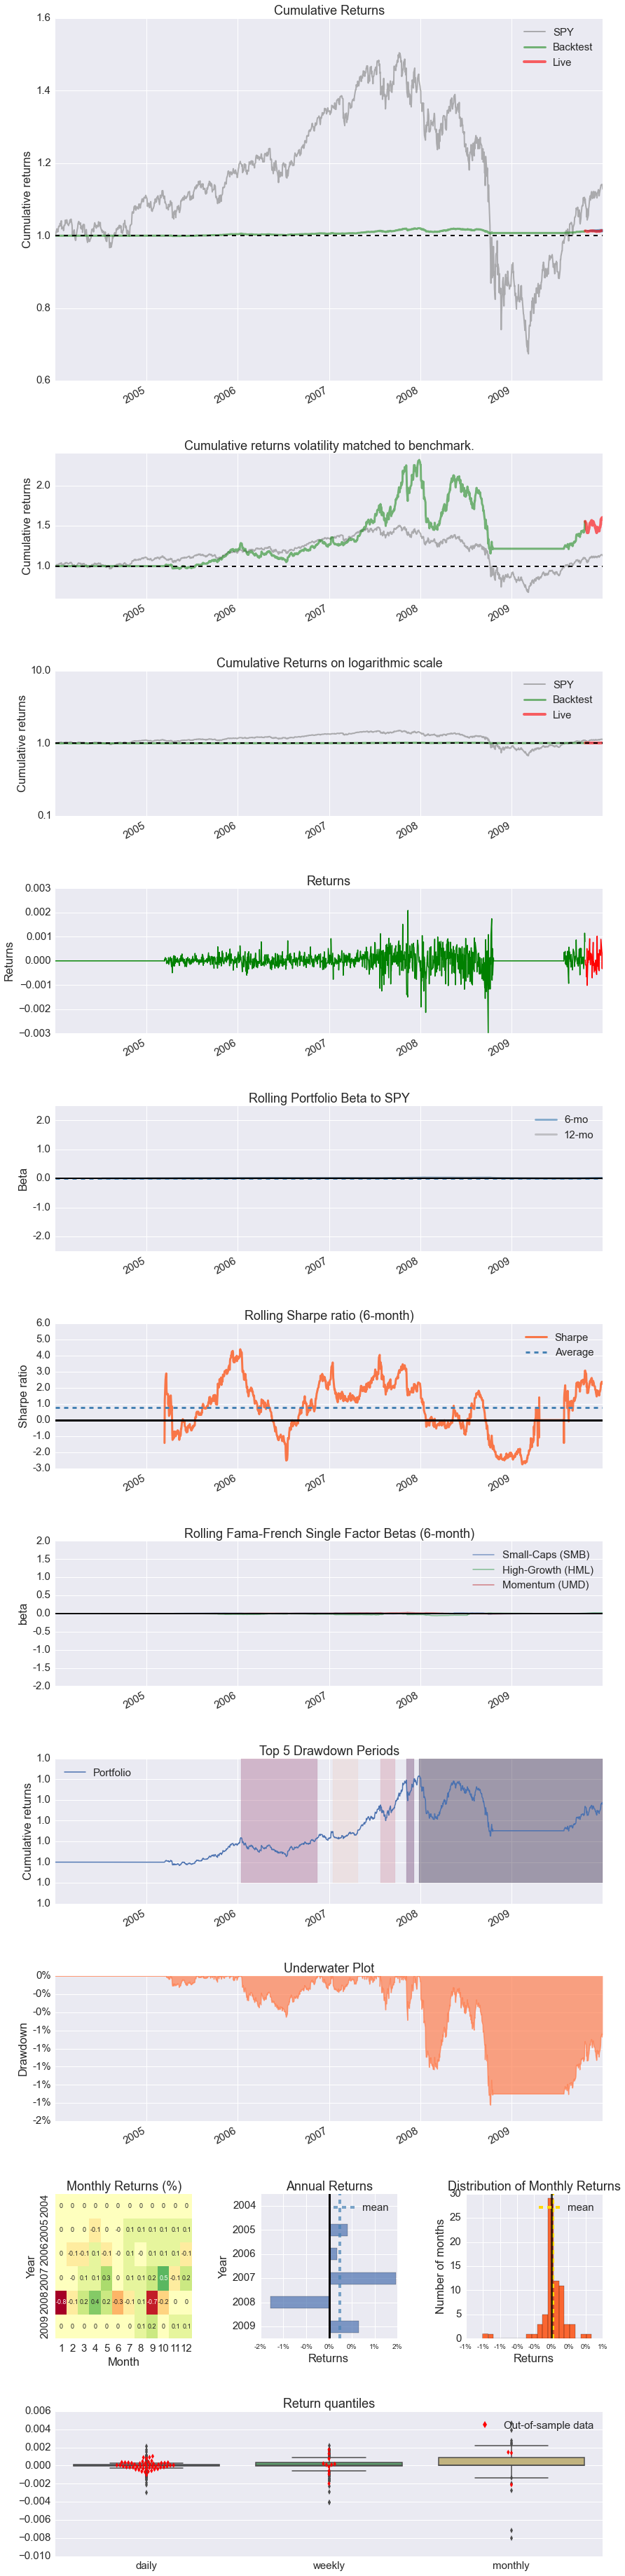

/Users/mrefermat/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Lehmann,-0.01%,-0.30%,0.11%
Aug07,0.00%,-0.10%,0.09%
Mar08,0.02%,-0.06%,0.10%
Sept08,-0.04%,-0.30%,0.11%
2009Q1,0.00%,0.00%,0.00%
2009Q2,0.00%,0.00%,0.00%
Low Volatility Bull Market,0.00%,-0.12%,0.11%
GFC Crash,-0.00%,-0.30%,0.21%
Recovery,0.00%,-0.10%,0.12%


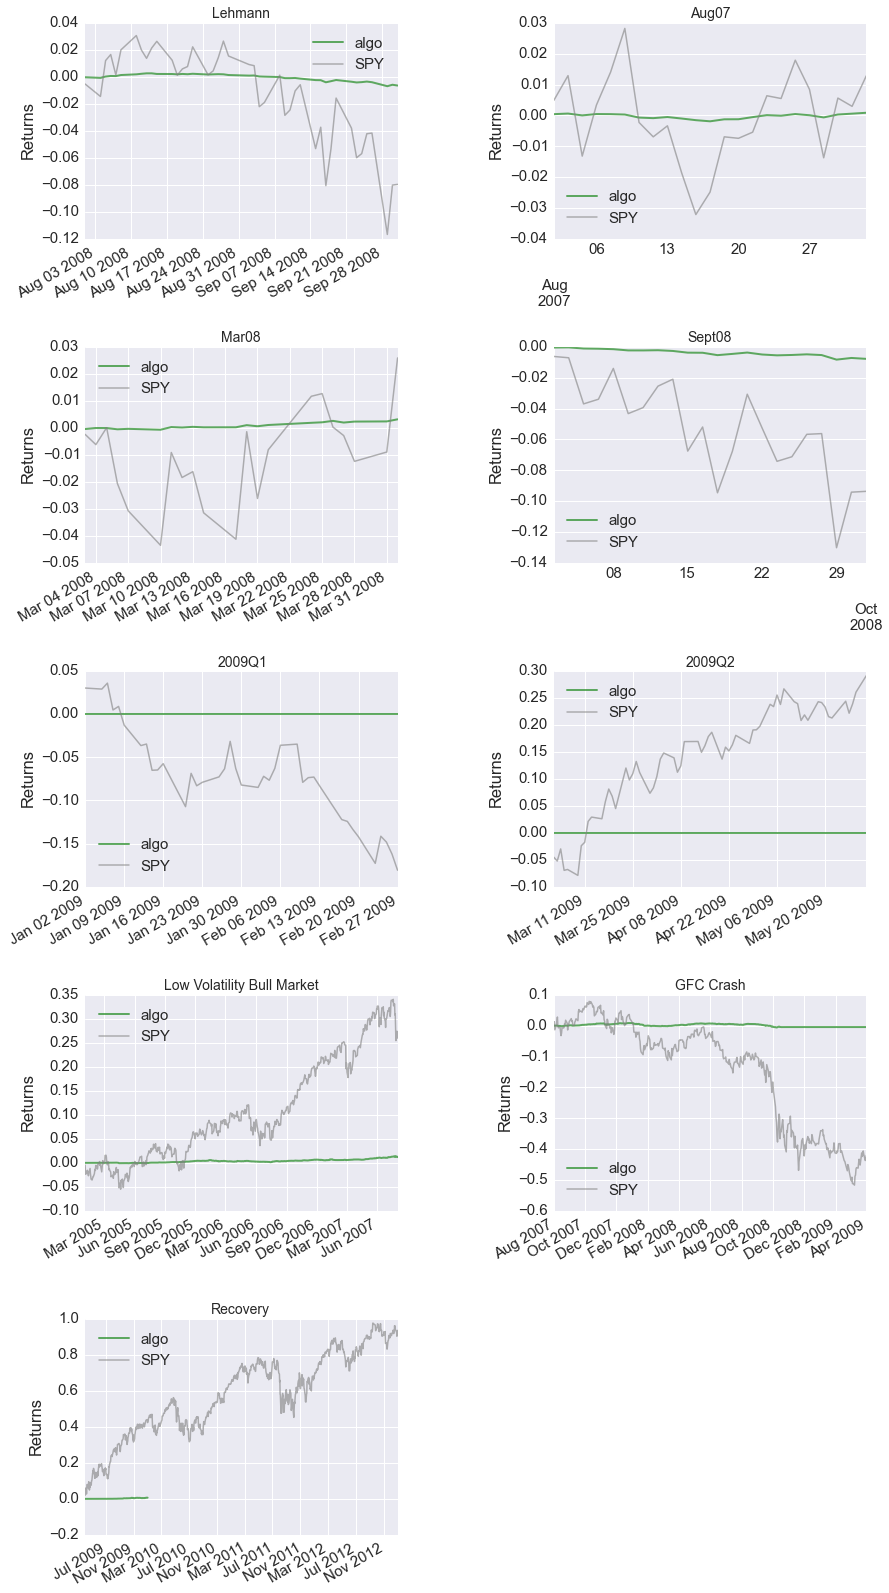

Top 10 long positions of all time,max
sid,
Equity(0 [AAPL]),2.73%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
Equity(0 [AAPL]),2.73%


All positions ever held,max
sid,
Equity(0 [AAPL]),2.73%


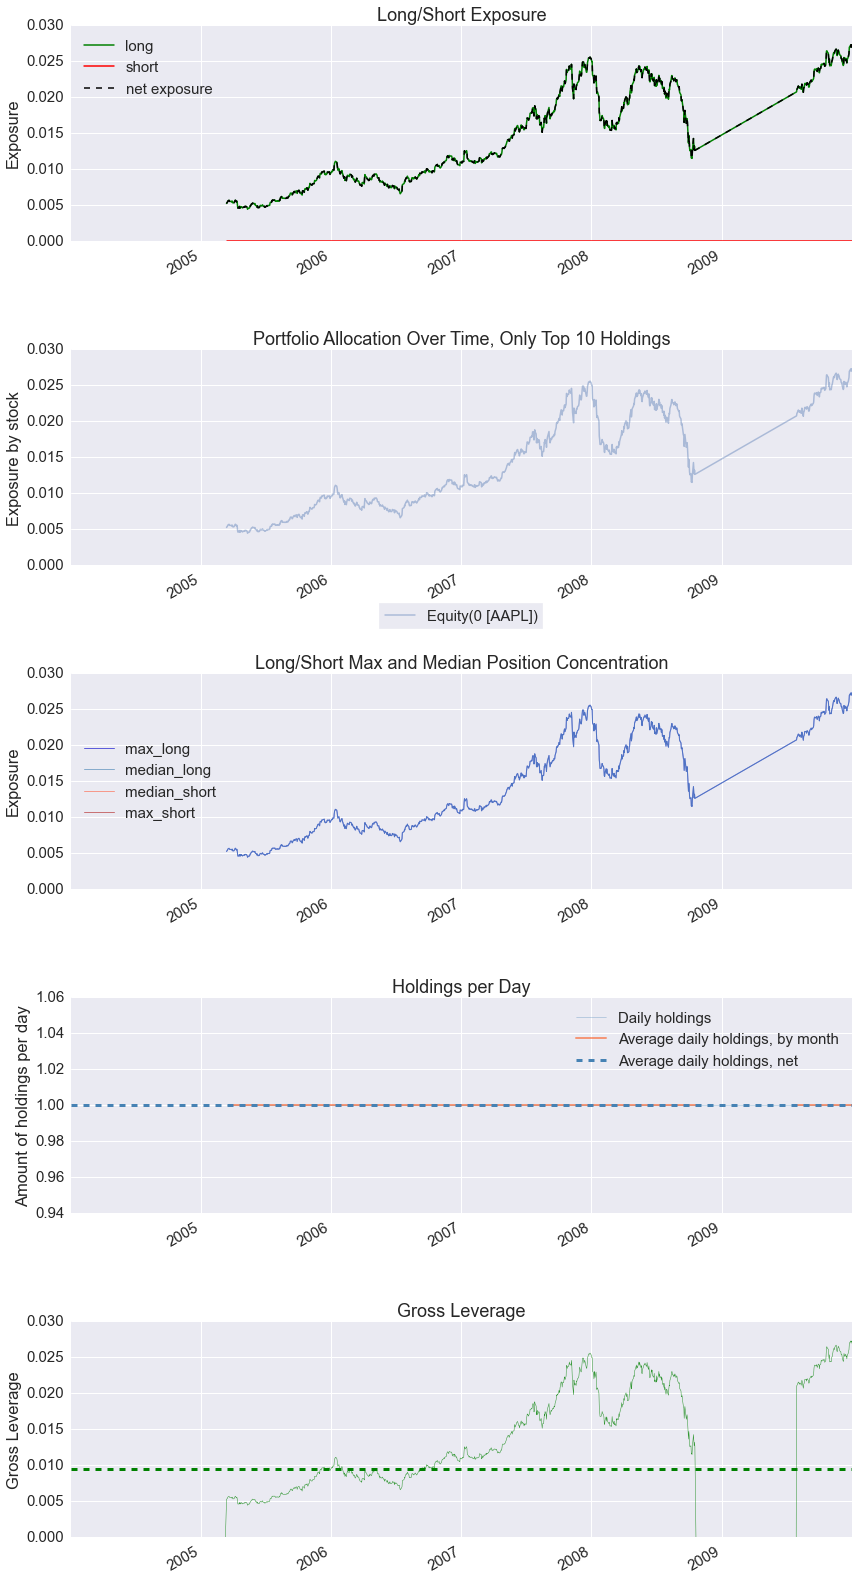

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pyfolio/plotting.py:1210: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  **kwargs)


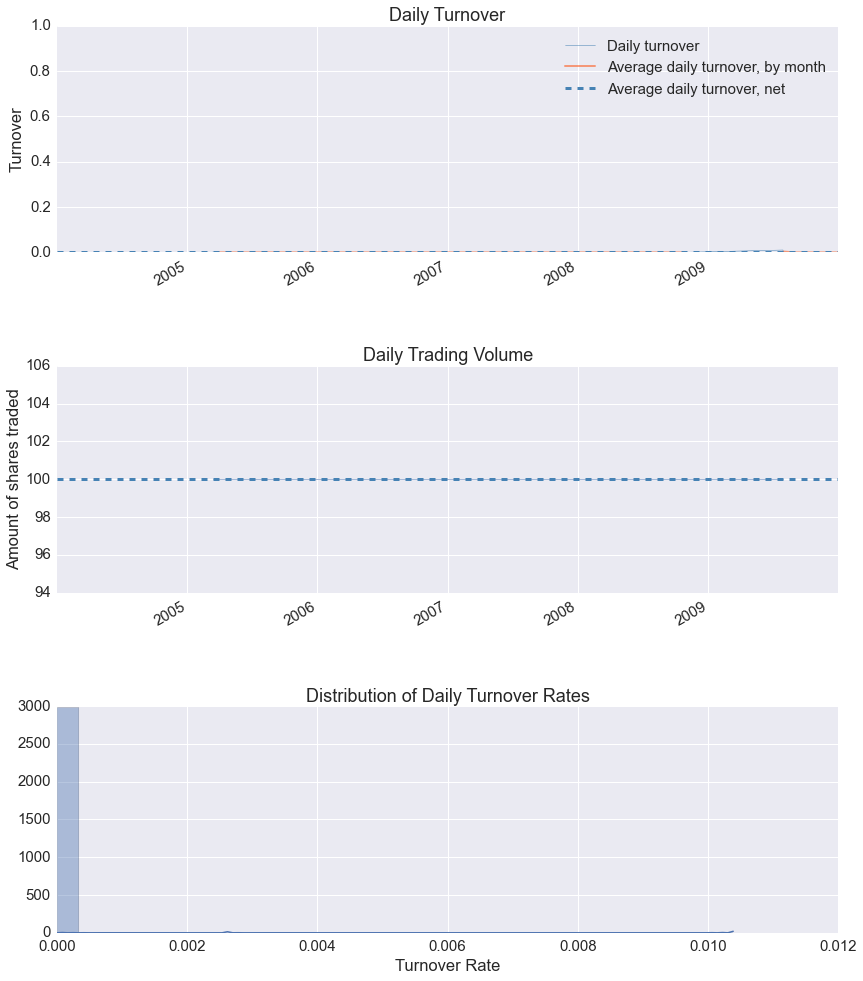

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pyfolio/tears.py:590: UserWarning: Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.
  Skipping round trip tearsheet.""", UserWarning)


In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22', round_trips=True)

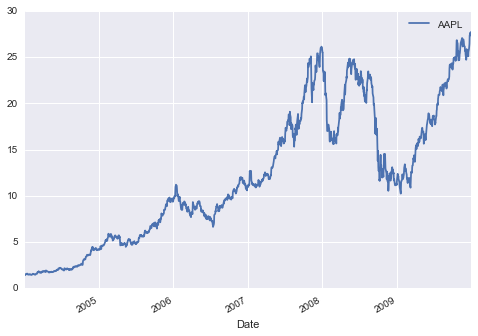